In [1]:
# Standard Libraries
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Deep Learning and PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
# Image Processing
from PIL import Image
from torchvision import transforms, models

# File Handling
import h5py

# Metrics and Evaluation
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

# Progress Visualization
from tqdm import tqdm



## Create Custom Dataset

In [2]:

class MultiInputDataset(Dataset):
    def __init__(self, hdf5_file, csv_file, transform=None):
        # Open the HDF5 file with error handling
        try:
            self.hdf5_file = h5py.File(hdf5_file, 'r')  # Read-only mode
        except Exception as e:
            raise IOError(f"Could not open HDF5 file: {hdf5_file}. Error: {e}")

        # Read the CSV file containing image labels and additional features
        try:
            self.labels_df = pd.read_csv(csv_file)
        except Exception as e:
            raise IOError(f"Could not read CSV file: {csv_file}. Error: {e}")

        # Ensure that all image IDs from the CSV are present in the HDF5 file
        self.image_ids = self.labels_df['isic_id'].values
        for image_id in self.image_ids:
            if str(image_id) not in self.hdf5_file.keys():
                raise ValueError(f"Image id {image_id} not found in HDF5 file.")

        # Store any transformations to be applied to the images
        self.transform = transform

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.labels_df)

    def __getitem__(self, idx):
        # Get the image ID from the CSV file based on index
        image_id = str(self.labels_df.iloc[idx]['isic_id'])

        # Load the image data from the HDF5 file
        image_bytes = self.hdf5_file[image_id][()]

        # Convert the image bytes to a PIL Image
        image = Image.open(io.BytesIO(image_bytes))

        # Apply any specified transformations to the image
        if self.transform:
            image = self.transform(image)

        # Retrieve the label
        label = torch.tensor(self.labels_df.iloc[idx]['target'], dtype=torch.long)  # Adjust dtype if needed

        # Retrieve other features, excluding 'isic_id' and 'target'
        other_variables = self.labels_df.iloc[idx].drop(['isic_id', 'target']).values.astype(float)

        # Convert other variables (metadata) to a tensor
        metadata_tensor = torch.tensor(other_variables, dtype=torch.float32)

        # Return the image, metadata, and label
        return image, metadata_tensor, label


In [3]:
# Define any necessary transformations for the image dataset


# Transformations for training set (with data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((225, 225)),  # Resize to 225x225
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random crop to 225x225 with scale
    transforms.RandomRotation(10),  # Randomly rotate images by 10 degrees
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Transformations for validation/test set (no data augmentation)
normal_transform = transforms.Compose([
    transforms.Resize((225, 225)),  # Ensure the image is resized to 225x225
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])




## Train DataLoader

In [4]:
# Initialize the dataset
train_dataset = MultiInputDataset(hdf5_file='../data/raw/train_images.hdf5', csv_file='../data/processed/processed-train-metadata1.csv', transform=normal_transform)
val_dataset = MultiInputDataset(hdf5_file='../data/raw/validation_image.hdf5', csv_file='../data/processed/processed-validation-metadata1.csv', transform=normal_transform)
# Create a DataLoader
train_dataloader = DataLoader(train_dataset,  batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset,  batch_size=64, shuffle=True)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Model Building

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class CustomImageFeatureResNet(nn.Module):
    def __init__(self, feature_input_size, pretrained=True):
        super(CustomImageFeatureResNet, self).__init__()

        # Load a pretrained ResNet model for image feature extraction (ResNet18 in this case)
        resnet = models.resnet18(pretrained=pretrained)  # Change to resnet50, resnet101 as needed
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove the final classification layer

        # The output of ResNet18's last conv layer is 512-dimensional (for ResNet50, it would be 2048)
        self.fc_image = nn.Linear(resnet.fc.in_features, 512)  # Adjust if using ResNet50

        # Fully connected layer for metadata (feature data)
        self.fc_metadata = nn.Linear(feature_input_size, 128)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)  # 50% dropout

        # Final fully connected layer for binary classification (combined image + feature input)
        self.fc_combined = nn.Linear(512 + 128, 1)  # For binary classification

    def forward(self, image, metadata):
        # Forward pass for the image through the ResNet (without the final classification layer)
        x = self.resnet(image)  # ResNet feature extraction
        x = x.view(x.size(0), -1)  # Flatten the ResNet output
        image_features = F.relu(self.fc_image(x))

        # Process metadata (feature data)
        metadata_features = F.relu(self.fc_metadata(metadata))

        # Ensure the batch sizes are consistent
        assert image_features.shape[0] == metadata_features.shape[0], \
            f"Batch sizes do not match! Image batch size: {image_features.shape[0]}, Metadata batch size: {metadata_features.shape[0]}"

        # Concatenate image features and metadata features
        combined_features = torch.cat((image_features, metadata_features), dim=1)

        # Dropout and final classification layer
        combined_features = self.dropout(combined_features)
        output = self.fc_combined(combined_features)

        # If you're using BCELoss, uncomment the next line to apply sigmoid
        output = torch.sigmoid(output)

        return output

## Model Training

In [7]:
# Function to compute partial AUC-above-TPR
def score(solution: np.array, submission: np.array, min_tpr: float = 0.80) -> float:
    """
    Compute the partial AUC by focusing on a specific range of true positive rates (TPR).
    
    Args:
        solution (np.array): Ground truth binary labels.
        submission (np.array): Model predictions.
        min_tpr (float): Minimum true positive rate to calculate partial AUC.
    
    Returns:
        float: The calculated partial AUC.
    
    Raises:
        ValueError: If the min_tpr is not within a valid range.
    """
    # Rescale the target to handle sklearn limitations and flip the predictions
    v_gt = abs(solution - 1)
    v_pred = -1.0 * submission
    max_fpr = abs(1 - min_tpr)

    # Compute ROC curve using sklearn
    fpr, tpr, _ = roc_curve(v_gt, v_pred)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError(f"Expected min_tpr in range [0, 1), got: {min_tpr}")
    
    # Interpolate for partial AUC
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)
    
    return partial_auc

# Training and validation loop function
def train_and_validate(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    early_stopping_patience: int = 5,
    min_tpr: float = 0.80
) -> nn.Module:
    """
    Train and validate a PyTorch model with early stopping, AUROC, partial AUC, and error handling.

    Args:
        model (nn.Module): The model to be trained and validated.
        train_dataloader (torch.utils.data.DataLoader): Dataloader for training data.
        val_dataloader (torch.utils.data.DataLoader): Dataloader for validation data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer to update the model.
        epochs (int): Number of training epochs.
        device (torch.device): The device (CPU or GPU) to use.
        early_stopping_patience (int): Early stopping patience.
        min_tpr (float): The minimum true positive rate for calculating partial AUC.
    
    Returns:
        nn.Module: The trained model.
    """
    # Initialize tracking variables
    best_val_loss = float('inf')
    best_epoch = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    early_stopping_counter = 0

    # Start the training and validation loop
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        all_train_labels = []
        all_train_probs = []

        progress_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch + 1}')

        try:
            # Loop through the training batches
            for i, (image, metadata, labels) in enumerate(progress_bar):
                image, metadata, labels = image.to(device), metadata.to(device), labels.float().to(device)
                labels = labels.unsqueeze(1)  # Adjust labels to have the right shape for binary classification

                optimizer.zero_grad()

                # Forward pass
                probs = model(image, metadata)

                if probs.shape != labels.shape:
                    raise ValueError(f"Shape mismatch: Predictions shape {probs.shape} does not match labels shape {labels.shape}")

                # Calculate loss and backpropagate
                loss = criterion(probs, labels)
                loss.backward()
                optimizer.step()

                # Update running loss
                running_train_loss += loss.item()

                # Store labels and predictions for accuracy calculations
                all_train_labels.extend(labels.cpu().detach().numpy())
                all_train_probs.extend(probs.cpu().detach().numpy())

                # Calculate binary predictions for training accuracy
                predicted_train = (probs >= 0.5).float()
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()

                # Update progress bar
                progress_bar.set_postfix(train_loss=running_train_loss / (i + 1))

            # Calculate training accuracy and loss
            train_accuracy = 100 * correct_train / total_train
            train_losses.append(running_train_loss / len(train_dataloader))
            train_accuracies.append(train_accuracy)

        except ValueError as ve:
            print(f"Error during training loop: {ve}")
            break

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_probs = []

        progress_bar = tqdm(val_dataloader, desc=f'Validating Epoch {epoch + 1}')

        with torch.no_grad():
            try:
                # Loop through the validation batches
                for i, (images, metadata, labels) in enumerate(progress_bar):
                    images, metadata, labels = images.to(device), metadata.to(device), labels.float().to(device)
                    labels = labels.unsqueeze(1)

                    probs = model(images, metadata)

                    loss = criterion(probs, labels)
                    running_val_loss += loss.item()

                    all_labels.extend(labels.cpu().detach().numpy())
                    all_probs.extend(probs.cpu().detach().numpy())

                    # Calculate binary predictions for validation accuracy
                    predicted = (probs >= 0.5).float()
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    progress_bar.set_postfix(val_loss=running_val_loss / (i + 1))

                val_accuracy = 100 * correct / total
                val_loss = running_val_loss / len(val_dataloader)
                val_accuracies.append(val_accuracy)
                val_losses.append(val_loss)

                # Calculate AUROC
                try:
                    valid_auroc = roc_auc_score(all_labels, all_probs)
                except ValueError as ve:
                    print(f"AUROC Calculation Error: {ve}")
                    valid_auroc = 0.0

                # Calculate partial AUC-above-TPR
                try:
                    partial_auroc = score(np.array(all_labels), np.array(all_probs), min_tpr=min_tpr)
                except ValueError as ve:
                    print(f"Partial AUC Calculation Error: {ve}")
                    partial_auroc = 0.0

                print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}, '
                      f'Val Accuracy: {val_accuracy:.2f}%, Val AUROC: {valid_auroc:.4f}, Partial AUROC: {partial_auroc:.4f}')

                # Early stopping based on validation loss
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_epoch = epoch + 1
                    early_stopping_counter = 0
                    torch.save(model.state_dict(), 'best_model.pth')
                else:
                    early_stopping_counter += 1

                if early_stopping_counter >= early_stopping_patience:
                    print(f"Early stopping triggered at epoch {epoch + 1}")
                    break

            except Exception as e:
                print(f"Error during validation loop: {e}")
                break

    print(f"Best Epoch: {best_epoch}, Best Validation Loss: {best_val_loss:.4f}")
    print('Training Complete')

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Generate classification report
    try:
        print("Classification Report:")
        print(classification_report(all_labels, (np.array(all_probs) >= 0.5).astype(int), target_names=['Class 0', 'Class 1']))
    except Exception as e:
        print(f"Error generating classification report: {e}")

    return model



## Model 1

In [8]:
model1 = CustomImageFeatureResNet(feature_input_size=9)  # Assuming 9 features for metadata
model1.to(device)
# Initialize optimizer
optimizer = optim.Adam(model1.parameters(), lr=0.001)
# Define the loss function with the class weights
criterion = nn.BCELoss()  # Binary classification loss
# Set the number of epochs
epochs = 20


/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Validating Epoch 1: 100%|██████████| 24/24 [01:10<00:00,  2.93s/it, val_loss=0.359]


Epoch [1/20], Train Loss: 0.4871, Val Loss: 0.3585, Val Accuracy: 85.57%, Val AUROC: 0.7102, Partial AUROC: 0.0499
Epoch 2/20


Validating Epoch 2: 100%|██████████| 24/24 [01:09<00:00,  2.88s/it, val_loss=0.458]


Epoch [2/20], Train Loss: 0.3699, Val Loss: 0.4577, Val Accuracy: 82.21%, Val AUROC: 0.8521, Partial AUROC: 0.1003
Epoch 3/20


Validating Epoch 3: 100%|██████████| 24/24 [01:09<00:00,  2.88s/it, val_loss=0.288]


Epoch [3/20], Train Loss: 0.3105, Val Loss: 0.2877, Val Accuracy: 83.22%, Val AUROC: 0.8656, Partial AUROC: 0.1226
Epoch 4/20


Validating Epoch 4: 100%|██████████| 24/24 [01:11<00:00,  2.97s/it, val_loss=0.301]


Epoch [4/20], Train Loss: 0.2482, Val Loss: 0.3012, Val Accuracy: 87.18%, Val AUROC: 0.8861, Partial AUROC: 0.1248
Epoch 5/20


Validating Epoch 5: 100%|██████████| 24/24 [01:06<00:00,  2.77s/it, val_loss=0.25] 


Epoch [5/20], Train Loss: 0.1802, Val Loss: 0.2495, Val Accuracy: 90.27%, Val AUROC: 0.8954, Partial AUROC: 0.1271
Epoch 6/20


Validating Epoch 6: 100%|██████████| 24/24 [01:06<00:00,  2.77s/it, val_loss=0.206]


Epoch [6/20], Train Loss: 0.1522, Val Loss: 0.2059, Val Accuracy: 94.23%, Val AUROC: 0.7653, Partial AUROC: 0.0532
Epoch 7/20


Validating Epoch 7: 100%|██████████| 24/24 [01:07<00:00,  2.79s/it, val_loss=1.37]


Epoch [7/20], Train Loss: 0.1453, Val Loss: 1.3696, Val Accuracy: 67.38%, Val AUROC: 0.8349, Partial AUROC: 0.1053
Epoch 8/20


Validating Epoch 8: 100%|██████████| 24/24 [01:14<00:00,  3.10s/it, val_loss=0.193]


Epoch [8/20], Train Loss: 0.1246, Val Loss: 0.1926, Val Accuracy: 93.15%, Val AUROC: 0.8817, Partial AUROC: 0.1245
Epoch 9/20


Validating Epoch 9: 100%|██████████| 24/24 [01:12<00:00,  3.00s/it, val_loss=0.146]


Epoch [9/20], Train Loss: 0.0645, Val Loss: 0.1464, Val Accuracy: 96.51%, Val AUROC: 0.8796, Partial AUROC: 0.1200
Epoch 10/20


Validating Epoch 10: 100%|██████████| 24/24 [01:08<00:00,  2.87s/it, val_loss=0.183]


Epoch [10/20], Train Loss: 0.0390, Val Loss: 0.1834, Val Accuracy: 95.03%, Val AUROC: 0.8746, Partial AUROC: 0.1210
Epoch 11/20


Validating Epoch 11: 100%|██████████| 24/24 [01:14<00:00,  3.10s/it, val_loss=0.254]


Epoch [11/20], Train Loss: 0.0310, Val Loss: 0.2539, Val Accuracy: 92.55%, Val AUROC: 0.8574, Partial AUROC: 0.1095
Epoch 12/20


Validating Epoch 12: 100%|██████████| 24/24 [01:11<00:00,  2.98s/it, val_loss=0.189]


Epoch [12/20], Train Loss: 0.0615, Val Loss: 0.1888, Val Accuracy: 94.03%, Val AUROC: 0.8672, Partial AUROC: 0.1175
Epoch 13/20


Validating Epoch 13: 100%|██████████| 24/24 [01:07<00:00,  2.80s/it, val_loss=0.244]


Epoch [13/20], Train Loss: 0.0328, Val Loss: 0.2440, Val Accuracy: 93.76%, Val AUROC: 0.8565, Partial AUROC: 0.1048
Epoch 14/20


Validating Epoch 14: 100%|██████████| 24/24 [01:08<00:00,  2.86s/it, val_loss=0.275]


Epoch [14/20], Train Loss: 0.0311, Val Loss: 0.2752, Val Accuracy: 94.97%, Val AUROC: 0.8445, Partial AUROC: 0.1057
Early stopping triggered at epoch 14
Best Epoch: 9, Best Validation Loss: 0.1464
Training Complete


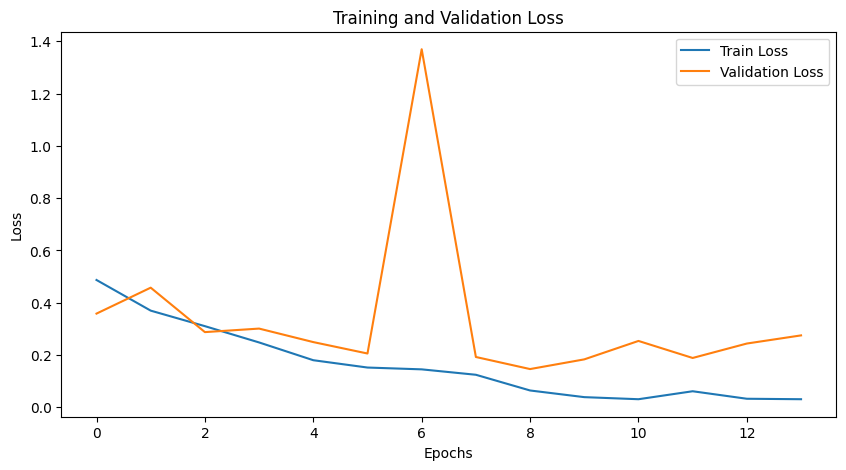

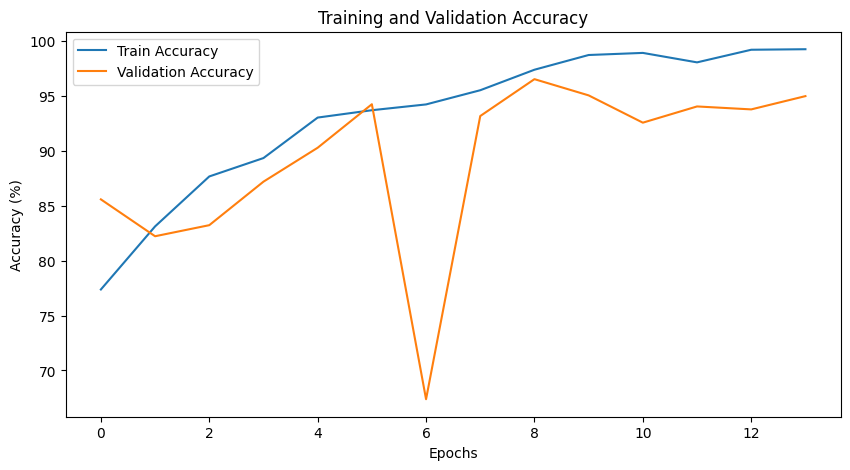

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.97      1431
     Class 1       0.35      0.31      0.32        59

    accuracy                           0.95      1490
   macro avg       0.66      0.64      0.65      1490
weighted avg       0.95      0.95      0.95      1490



CustomImageFeatureResNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [9]:



train_and_validate(model1,train_dataloader, val_dataloader, criterion, optimizer, epochs, device )

## Model 2

In [10]:
model2 = CustomImageFeatureResNet(feature_input_size=9)  # Assuming 9 features for metadata
model2.to(device)
# Initialize optimizer
optimizer = optim.SGD(model2.parameters(), lr=0.001)
# Define the loss function with the class weights
criterion = nn.BCELoss()  # Binary classification loss
# Set the number of epochs
epochs = 20


/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Validating Epoch 1: 100%|██████████| 24/24 [01:07<00:00,  2.80s/it, val_loss=0.484]


Epoch [1/20], Train Loss: 0.6494, Val Loss: 0.4835, Val Accuracy: 96.04%, Val AUROC: 0.5763, Partial AUROC: 0.0208
Epoch 2/20


Validating Epoch 2: 100%|██████████| 24/24 [01:08<00:00,  2.86s/it, val_loss=0.44] 


Epoch [2/20], Train Loss: 0.6371, Val Loss: 0.4399, Val Accuracy: 96.04%, Val AUROC: 0.5812, Partial AUROC: 0.0224
Epoch 3/20


Validating Epoch 3: 100%|██████████| 24/24 [01:09<00:00,  2.88s/it, val_loss=0.427]


Epoch [3/20], Train Loss: 0.6323, Val Loss: 0.4268, Val Accuracy: 96.04%, Val AUROC: 0.6200, Partial AUROC: 0.0318
Epoch 4/20


Validating Epoch 4: 100%|██████████| 24/24 [01:09<00:00,  2.88s/it, val_loss=0.421]


Epoch [4/20], Train Loss: 0.6218, Val Loss: 0.4208, Val Accuracy: 96.04%, Val AUROC: 0.6634, Partial AUROC: 0.0398
Epoch 5/20


Validating Epoch 5: 100%|██████████| 24/24 [01:09<00:00,  2.88s/it, val_loss=0.429]


Epoch [5/20], Train Loss: 0.6126, Val Loss: 0.4288, Val Accuracy: 96.04%, Val AUROC: 0.6879, Partial AUROC: 0.0439
Epoch 6/20


Validating Epoch 6: 100%|██████████| 24/24 [01:07<00:00,  2.81s/it, val_loss=0.42] 


Epoch [6/20], Train Loss: 0.6055, Val Loss: 0.4201, Val Accuracy: 96.04%, Val AUROC: 0.7171, Partial AUROC: 0.0529
Epoch 7/20


Validating Epoch 7: 100%|██████████| 24/24 [01:07<00:00,  2.79s/it, val_loss=0.407]


Epoch [7/20], Train Loss: 0.5989, Val Loss: 0.4068, Val Accuracy: 96.04%, Val AUROC: 0.7272, Partial AUROC: 0.0528
Epoch 8/20


Validating Epoch 8: 100%|██████████| 24/24 [01:08<00:00,  2.86s/it, val_loss=0.407]


Epoch [8/20], Train Loss: 0.5911, Val Loss: 0.4073, Val Accuracy: 96.04%, Val AUROC: 0.7430, Partial AUROC: 0.0560
Epoch 9/20


Validating Epoch 9: 100%|██████████| 24/24 [01:10<00:00,  2.95s/it, val_loss=0.405]


Epoch [9/20], Train Loss: 0.5865, Val Loss: 0.4047, Val Accuracy: 95.97%, Val AUROC: 0.7575, Partial AUROC: 0.0573
Epoch 10/20


Validating Epoch 10: 100%|██████████| 24/24 [01:08<00:00,  2.87s/it, val_loss=0.399]


Epoch [10/20], Train Loss: 0.5770, Val Loss: 0.3985, Val Accuracy: 95.97%, Val AUROC: 0.7674, Partial AUROC: 0.0635
Epoch 11/20


Validating Epoch 11: 100%|██████████| 24/24 [01:08<00:00,  2.87s/it, val_loss=0.404]


Epoch [11/20], Train Loss: 0.5675, Val Loss: 0.4040, Val Accuracy: 96.04%, Val AUROC: 0.7689, Partial AUROC: 0.0615
Epoch 12/20


Validating Epoch 12: 100%|██████████| 24/24 [01:11<00:00,  2.97s/it, val_loss=0.389]


Epoch [12/20], Train Loss: 0.5634, Val Loss: 0.3887, Val Accuracy: 95.91%, Val AUROC: 0.7855, Partial AUROC: 0.0679
Epoch 13/20


Validating Epoch 13: 100%|██████████| 24/24 [01:09<00:00,  2.90s/it, val_loss=0.381]


Epoch [13/20], Train Loss: 0.5594, Val Loss: 0.3807, Val Accuracy: 95.91%, Val AUROC: 0.7903, Partial AUROC: 0.0692
Epoch 14/20


Validating Epoch 14: 100%|██████████| 24/24 [01:09<00:00,  2.89s/it, val_loss=0.381]


Epoch [14/20], Train Loss: 0.5513, Val Loss: 0.3811, Val Accuracy: 95.91%, Val AUROC: 0.7868, Partial AUROC: 0.0667
Epoch 15/20


Validating Epoch 15: 100%|██████████| 24/24 [01:08<00:00,  2.86s/it, val_loss=0.379]


Epoch [15/20], Train Loss: 0.5425, Val Loss: 0.3791, Val Accuracy: 95.91%, Val AUROC: 0.7936, Partial AUROC: 0.0692
Epoch 16/20


Validating Epoch 16: 100%|██████████| 24/24 [01:08<00:00,  2.85s/it, val_loss=0.37] 


Epoch [16/20], Train Loss: 0.5355, Val Loss: 0.3700, Val Accuracy: 95.77%, Val AUROC: 0.8040, Partial AUROC: 0.0754
Epoch 17/20


Validating Epoch 17: 100%|██████████| 24/24 [01:11<00:00,  2.98s/it, val_loss=0.365]


Epoch [17/20], Train Loss: 0.5230, Val Loss: 0.3650, Val Accuracy: 95.91%, Val AUROC: 0.8042, Partial AUROC: 0.0754
Epoch 18/20


Validating Epoch 18: 100%|██████████| 24/24 [01:08<00:00,  2.86s/it, val_loss=0.375]


Epoch [18/20], Train Loss: 0.5138, Val Loss: 0.3750, Val Accuracy: 94.77%, Val AUROC: 0.8019, Partial AUROC: 0.0730
Epoch 19/20


Validating Epoch 19: 100%|██████████| 24/24 [01:08<00:00,  2.87s/it, val_loss=0.354]


Epoch [19/20], Train Loss: 0.5178, Val Loss: 0.3542, Val Accuracy: 94.90%, Val AUROC: 0.8084, Partial AUROC: 0.0757
Epoch 20/20


Validating Epoch 20: 100%|██████████| 24/24 [01:07<00:00,  2.80s/it, val_loss=0.352]


Epoch [20/20], Train Loss: 0.5011, Val Loss: 0.3516, Val Accuracy: 94.77%, Val AUROC: 0.8129, Partial AUROC: 0.0767
Best Epoch: 20, Best Validation Loss: 0.3516
Training Complete


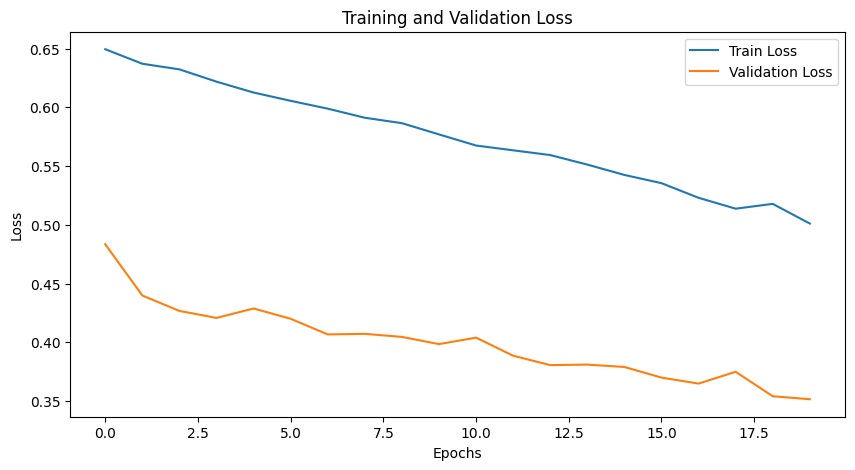

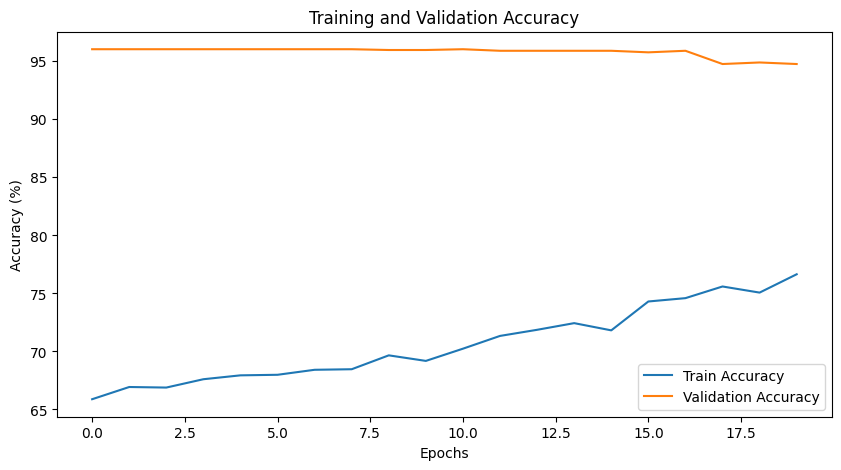

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.97      1431
     Class 1       0.31      0.27      0.29        59

    accuracy                           0.95      1490
   macro avg       0.64      0.62      0.63      1490
weighted avg       0.94      0.95      0.95      1490



CustomImageFeatureResNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [11]:

train_and_validate(model2,train_dataloader, val_dataloader, criterion, optimizer, epochs, device )

## Model 3

In [12]:
model3 = CustomImageFeatureResNet(feature_input_size=9)  # Assuming 9 features for metadata
model3.to(device)
# Initialize optimizer
optimizer = optim.SGD(model3.parameters(), lr=0.0001,weight_decay=1e-4)
# Define the loss function with the class weights
criterion = nn.BCELoss()  # Binary classification loss
# Set the number of epochs
epochs = 20
batch_size = 32

/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Epoch 1/20


Validating Epoch 1: 100%|██████████| 47/47 [01:06<00:00,  1.42s/it, val_loss=0.659]


Epoch [1/20], Train Loss: 0.6999, Val Loss: 0.6592, Val Accuracy: 77.05%, Val AUROC: 0.3767, Partial AUROC: 0.0063
Epoch 2/20


Validating Epoch 2: 100%|██████████| 47/47 [01:07<00:00,  1.44s/it, val_loss=0.62] 


Epoch [2/20], Train Loss: 0.6847, Val Loss: 0.6203, Val Accuracy: 92.28%, Val AUROC: 0.3632, Partial AUROC: 0.0067
Epoch 3/20


Validating Epoch 3: 100%|██████████| 47/47 [01:07<00:00,  1.43s/it, val_loss=0.586]


Epoch [3/20], Train Loss: 0.6740, Val Loss: 0.5864, Val Accuracy: 95.57%, Val AUROC: 0.3735, Partial AUROC: 0.0074
Epoch 4/20


Validating Epoch 4: 100%|██████████| 47/47 [01:06<00:00,  1.42s/it, val_loss=0.558]


Epoch [4/20], Train Loss: 0.6675, Val Loss: 0.5584, Val Accuracy: 96.04%, Val AUROC: 0.3819, Partial AUROC: 0.0084
Epoch 5/20


Validating Epoch 5: 100%|██████████| 47/47 [01:06<00:00,  1.42s/it, val_loss=0.541]


Epoch [5/20], Train Loss: 0.6630, Val Loss: 0.5414, Val Accuracy: 96.04%, Val AUROC: 0.3721, Partial AUROC: 0.0083
Epoch 6/20


Validating Epoch 6: 100%|██████████| 47/47 [01:07<00:00,  1.44s/it, val_loss=0.521]


Epoch [6/20], Train Loss: 0.6500, Val Loss: 0.5210, Val Accuracy: 96.04%, Val AUROC: 0.3960, Partial AUROC: 0.0105
Epoch 7/20


Validating Epoch 7: 100%|██████████| 47/47 [01:05<00:00,  1.39s/it, val_loss=0.506]


Epoch [7/20], Train Loss: 0.6518, Val Loss: 0.5059, Val Accuracy: 96.04%, Val AUROC: 0.4008, Partial AUROC: 0.0120
Epoch 8/20


Validating Epoch 8: 100%|██████████| 47/47 [01:05<00:00,  1.39s/it, val_loss=0.496]


Epoch [8/20], Train Loss: 0.6452, Val Loss: 0.4963, Val Accuracy: 96.04%, Val AUROC: 0.4022, Partial AUROC: 0.0107
Epoch 9/20


Validating Epoch 9: 100%|██████████| 47/47 [01:07<00:00,  1.43s/it, val_loss=0.483]


Epoch [9/20], Train Loss: 0.6446, Val Loss: 0.4831, Val Accuracy: 96.04%, Val AUROC: 0.4151, Partial AUROC: 0.0131
Epoch 10/20


Validating Epoch 10: 100%|██████████| 47/47 [01:04<00:00,  1.38s/it, val_loss=0.477]


Epoch [10/20], Train Loss: 0.6357, Val Loss: 0.4769, Val Accuracy: 96.04%, Val AUROC: 0.4274, Partial AUROC: 0.0137
Epoch 11/20


Validating Epoch 11: 100%|██████████| 47/47 [01:06<00:00,  1.42s/it, val_loss=0.47] 


Epoch [11/20], Train Loss: 0.6341, Val Loss: 0.4700, Val Accuracy: 96.04%, Val AUROC: 0.4331, Partial AUROC: 0.0140
Epoch 12/20


Validating Epoch 12: 100%|██████████| 47/47 [01:07<00:00,  1.44s/it, val_loss=0.465]


Epoch [12/20], Train Loss: 0.6386, Val Loss: 0.4655, Val Accuracy: 96.04%, Val AUROC: 0.4561, Partial AUROC: 0.0164
Epoch 13/20


Validating Epoch 13: 100%|██████████| 47/47 [01:07<00:00,  1.43s/it, val_loss=0.46] 


Epoch [13/20], Train Loss: 0.6376, Val Loss: 0.4599, Val Accuracy: 96.04%, Val AUROC: 0.4592, Partial AUROC: 0.0170
Epoch 14/20


Validating Epoch 14: 100%|██████████| 47/47 [01:07<00:00,  1.43s/it, val_loss=0.454]


Epoch [14/20], Train Loss: 0.6331, Val Loss: 0.4540, Val Accuracy: 96.04%, Val AUROC: 0.4620, Partial AUROC: 0.0180
Epoch 15/20


Validating Epoch 15: 100%|██████████| 47/47 [01:07<00:00,  1.44s/it, val_loss=0.452]


Epoch [15/20], Train Loss: 0.6315, Val Loss: 0.4521, Val Accuracy: 96.04%, Val AUROC: 0.4847, Partial AUROC: 0.0194
Epoch 16/20


Validating Epoch 16: 100%|██████████| 47/47 [01:07<00:00,  1.43s/it, val_loss=0.447]


Epoch [16/20], Train Loss: 0.6296, Val Loss: 0.4473, Val Accuracy: 96.04%, Val AUROC: 0.4830, Partial AUROC: 0.0192
Epoch 17/20


Validating Epoch 17: 100%|██████████| 47/47 [01:07<00:00,  1.43s/it, val_loss=0.444]


Epoch [17/20], Train Loss: 0.6327, Val Loss: 0.4435, Val Accuracy: 96.04%, Val AUROC: 0.4997, Partial AUROC: 0.0210
Epoch 18/20


Validating Epoch 18: 100%|██████████| 47/47 [01:07<00:00,  1.43s/it, val_loss=0.443]


Epoch [18/20], Train Loss: 0.6285, Val Loss: 0.4429, Val Accuracy: 96.04%, Val AUROC: 0.5151, Partial AUROC: 0.0219
Epoch 19/20


Validating Epoch 19: 100%|██████████| 47/47 [01:06<00:00,  1.42s/it, val_loss=0.442]


Epoch [19/20], Train Loss: 0.6254, Val Loss: 0.4423, Val Accuracy: 96.04%, Val AUROC: 0.5279, Partial AUROC: 0.0251
Epoch 20/20


Validating Epoch 20: 100%|██████████| 47/47 [01:06<00:00,  1.42s/it, val_loss=0.44] 


Epoch [20/20], Train Loss: 0.6192, Val Loss: 0.4397, Val Accuracy: 96.04%, Val AUROC: 0.5377, Partial AUROC: 0.0247
Best Epoch: 20, Best Validation Loss: 0.4397
Training Complete


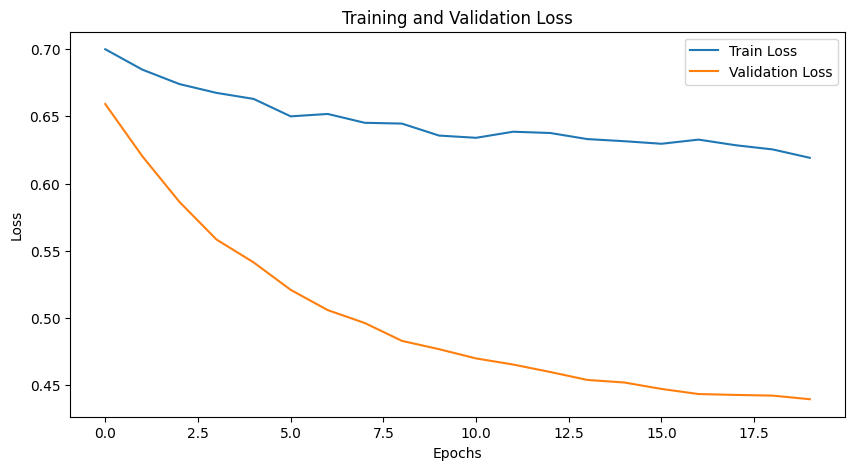

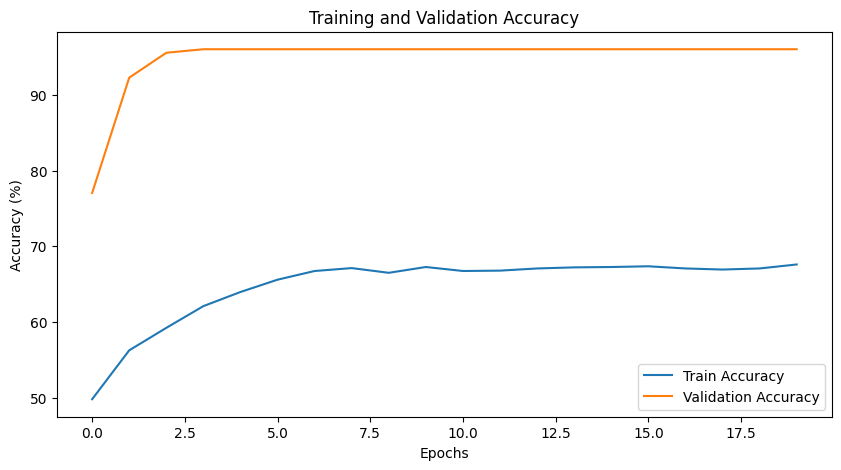

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98      1431
     Class 1       0.00      0.00      0.00        59

    accuracy                           0.96      1490
   macro avg       0.48      0.50      0.49      1490
weighted avg       0.92      0.96      0.94      1490



/opt/tljh/user/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/tljh/user/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/tljh/user/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CustomImageFeatureResNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [14]:
train_and_validate(model3,train_dataloader, val_dataloader, criterion, optimizer, epochs, device )